In [1]:
import os, sys
sys.path.append("../../common/")
from python_tools import *
import scipy.optimize
import numba_scipy
from numba import jit, float32

python tools loaded.


In [2]:
%matplotlib notebook

In [3]:
cov_file = uproot.open("/Users/wketchum/Data/MicroBooNE/LEEFits/dllee_fd1/total_sys_pred.SBNcovar.root")
mc_file = uproot.open("/Users/wketchum/Data/MicroBooNE/LEEFits/dllee_fd1/sens_pred.SBNspec.root")
data_file = uproot.open("/Users/wketchum/Data/MicroBooNE/LEEFits/dllee_fd1/fakedata.SBNspec.root")

In [4]:
print(cov_file.keys())
print(mc_file.keys())
print(data_file.keys())

[b'full_covariance;1', b'frac_covariance;1', b'full_correlation;1', b'collapsed_covariance;1', b'collapsed_frac_covariance;1', b'collapsed_correlation;1']
[b'nu_uBooNE_1e1p_bnb;1', b'nu_uBooNE_1e1p_lee;1', b'nu_uBooNE_1mu1p_bnb;1']
[b'nu_uBooNE_1e1p_bnb;1', b'nu_uBooNE_1e1p_lee;1', b'nu_uBooNE_1mu1p_bnb;1']


In [5]:
NUE_EXP = mc_file["nu_uBooNE_1e1p_bnb"].numpy()[0]
NUMU_EXP = mc_file["nu_uBooNE_1mu1p_bnb"].numpy()[0]
SIG_EXP = mc_file["nu_uBooNE_1e1p_lee"].numpy()[0]

DATA_EXP = np.append(np.copy(NUE_EXP),NUMU_EXP)
SIG_EXP = np.append(SIG_EXP,np.full_like(NUMU_EXP,0))

In [6]:
NUE_OBS = data_file["nu_uBooNE_1e1p_bnb"].numpy()[0]
NUMU_OBS = data_file["nu_uBooNE_1mu1p_bnb"].numpy()[0]
DATA_OBS = np.append(np.copy(NUE_OBS),NUMU_OBS)

In [7]:
m = cov_file["collapsed_covariance"]
M_COV_SYS = np.copy(m._fElements.reshape(m._fNrows, m._fNcols))
M_COV_SYS = np.float32(M_COV_SYS)
M_COV_NUE_SYS = M_COV_SYS[:10,:10]
M_COV_NUMU_SYS = M_COV_SYS[10:,10:]
M_COV_EM_SYS = M_COV_SYS[:10,10:]
M_COV_ME_SYS = M_COV_SYS[10:,:10]

M_COV_SYS_INV = np.linalg.inv(M_COV_SYS)
M_COV_NUE_SYS_INV = np.linalg.inv(M_COV_NUE_SYS)
M_COV_NUMU_SYS_INV = np.linalg.inv(M_COV_NUMU_SYS)

M_COV = np.copy(M_COV_SYS) + np.diagflat(DATA_EXP)
M_COV_SIG = np.copy(M_COV_SYS) + np.diagflat(DATA_EXP+SIG_EXP)

M_COV_NUE = M_COV[:10,:10]
M_COV_NUMU = M_COV[10:,10:]
M_COV_EM = M_COV[:10,10:]
M_COV_ME = M_COV[10:,:10]

M_COV_INV = np.linalg.inv(M_COV)
M_COV_SIG_INV = np.linalg.inv(M_COV_SIG)
M_COV_NUE_INV = np.linalg.inv(M_COV_NUE)
M_COV_NUMU_INV = np.linalg.inv(M_COV_NUMU)

IDENTITY_FULL = np.identity(len(SIG_EXP))

In [8]:
#useful for speedups
M_INV_S = np.matmul(M_COV_INV,np.diagflat(SIG_EXP))
M_INV_S_M_INV = np.matmul(M_INV_S,M_COV_INV)

In [9]:
def M_COV_INV_FAST_FULL(mu=1.0):
    #just in case you ask for zero...
    if np.isclose(mu,0.0): 
        return M_COV_INV
    else:
        return M_COV_INV - mu*np.matmul(np.linalg.inv(IDENTITY_FULL+mu*M_INV_S),
                                        M_INV_S_M_INV)

In [10]:
def CHI2(diff,m_cov_inv):
    return np.matmul(np.transpose(diff),np.matmul(m_cov_inv,diff))

def COND_EXP(diff1,exp2,m_cov_11_inv,m_cov_21):
    return exp2 + np.matmul(m_cov_21,np.matmul(m_cov_11_inv,diff1))

def COND_COV(m_cov_22,m_cov_11_inv,m_cov_12,m_cov_21):
    return m_cov_22 - np.matmul(m_cov_21,np.matmul(m_cov_11_inv,m_cov_12))

def CHI2_SIG_FULL(x,data):
    return CHI2(data - (x*SIG_EXP+DATA_EXP),M_COV_INV_FAST_FULL(x))

In [47]:
NUE_EXP_COND = COND_EXP(NUMU_OBS-NUMU_EXP,NUE_EXP,M_COV_NUMU_INV,M_COV_EM)
#M_COV_COND_SYS = COND_COV(M_COV_NUE_SYS,M_COV_NUMU_SYS_INV,M_COV_ME_SYS,M_COV_EM_SYS)
#M_COV_COND = np.copy(M_COV_COND_SYS) + np.diagflat(NUE_EXP_COND)
#M_COV_COND_INV = np.linalg.inv(M_COV_COND)

M_COV_COND_SYS = COND_COV(M_COV_NUE_SYS,np.linalg.inv(M_COV_NUMU_SYS+np.diagflat(NUMU_EXP)),M_COV_ME_SYS,M_COV_EM_SYS)
M_COV_COND = np.copy(M_COV_COND_SYS) + np.diagflat(NUE_EXP_COND)
M_COV_COND_INV = np.linalg.inv(M_COV_COND)

SIG_EXP_COND = SIG_EXP[:10]# * (NUE_EXP_COND)/NUE_EXP
M_COV_SIG_COND = np.copy(M_COV_COND_SYS) + np.diagflat(SIG_EXP_COND)+np.diagflat(NUE_EXP_COND)
M_COV_SIG_COND_INV = np.linalg.inv(M_COV_SIG_COND)


In [48]:
IDENTITY_COND = np.identity(len(SIG_EXP_COND))
M_INV_S_COND = np.matmul(M_COV_COND_INV,np.diagflat(SIG_EXP_COND))
M_INV_S_M_INV_COND = np.matmul(M_INV_S_COND,M_COV_COND_INV)

In [49]:
def M_COV_INV_FAST_COND(mu=1.0):
    #just in case you ask for zero...
    if np.isclose(mu,0.0): 
        return M_COV_COND_INV
    else:
        return M_COV_COND_INV - mu*np.matmul(np.linalg.inv(IDENTITY_COND+mu*M_INV_S_COND),
                                        M_INV_S_M_INV_COND)
    
def CHI2_SIG_COND(x,data):
    return CHI2(data - (x*SIG_EXP_COND+NUE_EXP_COND),M_COV_INV_FAST_COND(x))

<IPython.core.display.Javascript object>


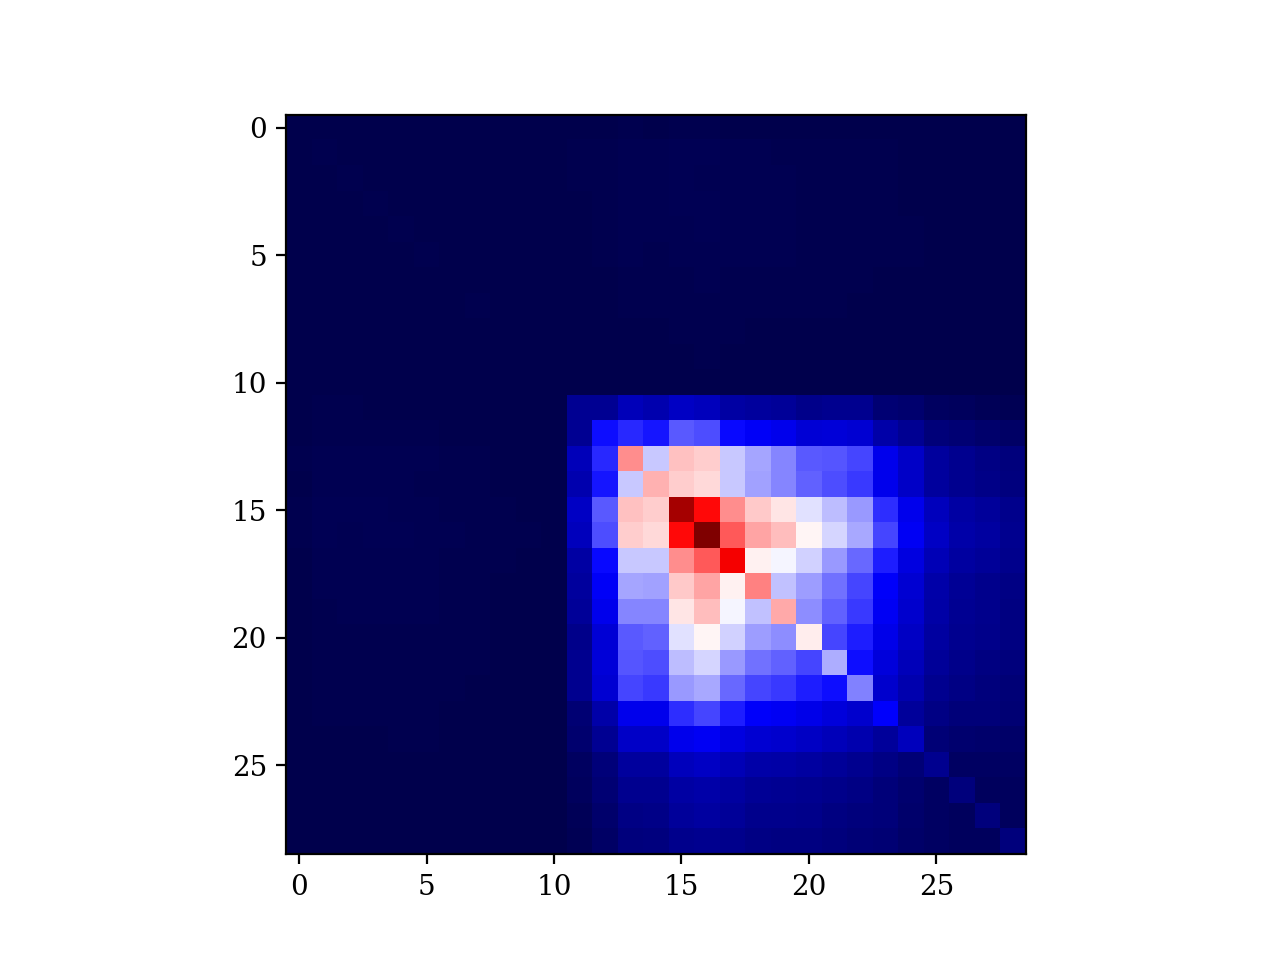

In [50]:
fig = plt.subplots()

#plt.imshow(M_COV,origin={'lower','lower'})
plt.imshow(M_COV)

In [51]:
def GET_PE(exp,m_cov_sys):
    return np.random.poisson(np.clip(np.random.multivariate_normal(exp, m_cov_sys),0,1e9))

In [52]:
def RUN_PES_FULL(n_pes,mu_true,verbose=False):
    
    tot_exp = DATA_EXP+mu_true*SIG_EXP
    df_pes = pd.DataFrame(index=np.arange(0,n_pes),columns=["mu_true","chi2_h0","chi2_hs","chi2_h1","chi2_hb","chi2_diff","mu_fit","pe_data"])
    
    m_cov_true_inv = M_COV_INV_FAST_FULL(mu_true)
    
    for i_pe in range(int(n_pes)):
        my_pe = GET_PE(tot_exp,M_COV_SYS)
        chi2_h0 = CHI2(my_pe-DATA_EXP,M_COV_INV)
        chi2_hs = CHI2(my_pe-(SIG_EXP+DATA_EXP),M_COV_SIG_INV)
        chi2_h1 = CHI2(my_pe-tot_exp,m_cov_true_inv)
        x0 = [np.max([0.1,mu_true])]
        res = scipy.optimize.minimize(CHI2_SIG_FULL,x0,
                                      args=(my_pe),
                                      bounds=[(0,100.)])
        chi2_hb = CHI2_SIG_FULL(res.x[0],my_pe)
        df_pes.loc[i_pe] = [mu_true,chi2_h0,chi2_hs,chi2_h1,chi2_hb,chi2_h1-chi2_hb,res.x[0],my_pe]
        i_pe+=1
        
        if(i_pe%1000==0 and verbose):
            print("\t\t\t finished PE %d"%i_pe)
        
    return df_pes

def RUN_PES_COND(n_pes,mu_true,verbose=False):
    
    tot_exp = NUE_EXP_COND+mu_true*SIG_EXP_COND
    df_pes = pd.DataFrame(index=np.arange(0,n_pes),columns=["mu_true","chi2_h0","chi2_hs","chi2_h1","chi2_hb","chi2_diff","mu_fit","pe_data"])
    
    m_cov_true_inv = M_COV_INV_FAST_COND(mu_true)
    
    for i_pe in range(int(n_pes)):
        my_pe = GET_PE(tot_exp,M_COV_COND_SYS)
        chi2_h0 = CHI2(my_pe-NUE_EXP_COND,M_COV_COND_INV)
        chi2_hs = CHI2(my_pe-(SIG_EXP_COND+NUE_EXP_COND),M_COV_SIG_COND_INV)
        chi2_h1 = CHI2(my_pe-tot_exp,m_cov_true_inv)
        x0 = [np.max([0.1,mu_true])]
        res = scipy.optimize.minimize(CHI2_SIG_COND,x0,
                                      args=(my_pe),
                                      bounds=[(0,100.)])
        chi2_hb = CHI2_SIG_COND(res.x[0],my_pe)
        df_pes.loc[i_pe] = [mu_true,chi2_h0,chi2_hs,chi2_h1,chi2_hb,chi2_h1-chi2_hb,res.x[0],my_pe]
        i_pe+=1
        
        if(i_pe%1000==0 and verbose):
            print("\t\t\t finished PE %d"%i_pe)
        
    return df_pes

In [17]:
RUN_PES_FULL(100,0.5,True)

/Library/Python/3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


,mu_true,chi2_h0,chi2_hs,chi2_h1,chi2_hb,chi2_diff,mu_fit,pe_data
0,0.5,22.447,24.7083,22.3445,21.8566,0.487923,0.228402,"[1, 5, 1, 5, 2, 2, 2, 3, 2, 0, 2, 19, 61, 93, ..."
1,0.5,28.9038,25.2389,25.1963,24.9328,0.263531,0.72473,"[0, 7, 8, 4, 4, 5, 2, 2, 4, 1, 2, 43, 73, 140,..."
2,0.5,43.9462,35.9802,36.9858,35.9395,1.04622,0.907037,"[0, 9, 4, 2, 1, 5, 2, 3, 1, 4, 2, 22, 44, 78, ..."
3,0.5,18.3336,10.1663,11.1753,10.1418,1.03345,0.92401,"[2, 8, 4, 6, 5, 5, 4, 3, 2, 3, 1, 27, 70, 111,..."
4,0.5,28.069,17.0238,18.9238,17.0149,1.90891,1.04303,"[1, 10, 5, 3, 2, 2, 3, 2, 2, 3, 0, 23, 62, 107..."
...,...,...,...,...,...,...,...,...
95,0.5,38.2558,37.9607,36.6873,36.6686,0.0187511,0.441076,"[1, 5, 7, 4, 1, 5, 2, 4, 1, 3, 1, 35, 80, 122,..."
96,0.5,43.3767,42.0639,41.2334,41.2274,0.00602562,0.534625,"[0, 4, 3, 5, 3, 1, 0, 4, 0, 1, 1, 4, 14, 35, 2..."
97,0.5,51.3994,34.0289,39.6625,30.9698,8.69273,1.95417,"[1, 4, 15, 4, 6, 4, 4, 2, 1, 1, 1, 39, 71, 125..."
98,0.5,57.9093,39.0761,43.4238,38.2454,5.17841,1.43607,"[2, 12, 3, 6, 7, 5, 0, 2, 6, 0, 1, 42, 63, 102..."


In [53]:
RUN_PES_COND(100,1.0,True)

/Library/Python/3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


,mu_true,chi2_h0,chi2_hs,chi2_h1,chi2_hb,chi2_diff,mu_fit,pe_data
0,1,9.19436,9.90608,9.90608,8.16973,1.73635,0.351085,"[0, 5, 3, 6, 2, 2, 4, 0, 2, 1]"
1,1,22.7977,5.02979,5.02979,4.96115,0.0686413,1.1191,"[3, 6, 6, 4, 5, 4, 2, 6, 2, 1]"
2,1,20.0957,10.3514,10.3514,10.2938,0.0576555,0.896583,"[0, 10, 2, 2, 1, 1, 3, 2, 1, 1]"
3,1,13.0546,12.1087,12.1087,11.1025,1.00618,0.499613,"[0, 5, 6, 2, 5, 4, 4, 6, 4, 1]"
4,1,14.5695,2.64758,2.64758,2.63383,0.0137592,0.947772,"[2, 8, 4, 4, 3, 2, 4, 3, 2, 1]"
...,...,...,...,...,...,...,...,...
95,1,31.5395,7.9694,7.9694,6.89632,1.07309,1.47216,"[2, 11, 6, 2, 5, 4, 3, 1, 0, 3]"
96,1,17.7048,9.8345,9.8345,9.83306,0.00143787,1.01948,"[1, 6, 7, 3, 8, 1, 2, 1, 1, 2]"
97,1,25.1299,7.99599,7.99599,7.84707,0.148918,1.17455,"[2, 10, 1, 3, 7, 2, 3, 2, 2, 2]"
98,1,23.663,5.02077,5.02077,4.70455,0.316218,1.25376,"[2, 10, 5, 2, 5, 5, 1, 2, 3, 2]"


In [19]:
TRUE_VALS = np.arange(0,5.05,0.05)
N_PES = 5e4

In [55]:
TRUE_VALS2 = np.arange(0,5.1,0.1)
N_PES2 = 1e4

In [20]:
CHI2(DATA_OBS-DATA_EXP,M_COV_INV)

80.10370219830203

In [21]:
df_pes_tot = pd.DataFrame()
for x in TRUE_VALS:
    print("\tRunning x=%f"%x)
    df_pes_tot = df_pes_tot.append(RUN_PES_FULL(N_PES,x,True))

	Running x=0.000000


/Library/Python/3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 460

			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=0.400000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000

			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=0.750000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000

			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=1.150000
			 finished PE 1000
			 finished PE 2000
			 finished PE

			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=1.500000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000

			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=1.850000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000

			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=2.250000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000

			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=2.600000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000

			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 

			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=3.350000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000

			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=3.700000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000

			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=4.100000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6

			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=4.450000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000

			 finished PE 50000
	Running x=4.800000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000

In [56]:
df_pes_cond = pd.DataFrame()
for x in TRUE_VALS2:
    print("\tRunning x=%f"%x)
    df_pes_cond = df_pes_cond.append(RUN_PES_COND(N_PES2,x,True))

	Running x=0.000000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
	Running x=0.100000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
	Running x=0.200000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
	Running x=0.300000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
	Running x=0.400000
			 finished PE 1000
			 finished PE 2000
			 finished P

			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
	Running x=3.600000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
	Running x=3.700000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
	Running x=3.800000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
	Running x=3.900000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished 

In [23]:
df_pes_tot.to_hdf("/Users/wketchum/Data/MicroBooNE/LEEFits/fd1_dfs.h5","df_pes_tot")
df_pes_cond.to_hdf("/Users/wketchum/Data/MicroBooNE/LEEFits/fd1_dfs.h5","df_pes_cond")

/Library/Python/3.8/site-packages/pandas/core/generic.py:2434: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['mu_true', 'chi2_h0', 'chi2_hs', 'chi2_h1', 'chi2_hb', 'chi2_diff',
       'mu_fit', 'pe_data'],
      dtype='object')]

  pytables.to_hdf(


In [ ]:
df_pes_tot

In [ ]:
df_pes_cond

In [24]:
SIGMA1 = scipy.stats.norm(0,1).cdf(1)-scipy.stats.norm(0,1).cdf(-1)
SIGMA2 = scipy.stats.norm(0,1).cdf(2)-scipy.stats.norm(0,1).cdf(-2)
SIGMA3 = scipy.stats.norm(0,1).cdf(3)-scipy.stats.norm(0,1).cdf(-3)

In [25]:
def GET_CRITICAL_VALUES(true_vals,quantiles,df_pes):

    critical_vals = np.empty((len(quantiles),len(true_vals)))

    for ix in range(len(true_vals)):
        x = true_vals[ix]
        qstring=str("mu_true>(%f) and mu_true<(%f)"%(x-0.0001,x+0.0001))
        df_pes['mu_true'] = df_pes['mu_true'].astype(float)
        cvals = np.quantile(df_pes.query(qstring)["chi2_diff"],quantiles)
        
        for iv in range(len(cvals)):
            critical_vals[iv,ix] = cvals[iv]

    return critical_vals

In [26]:
def CHI2_DIFF_FULL(data,x_vals):
    x0 = [0.1]
    res = scipy.optimize.minimize(CHI2_SIG_FULL,x0,
                                  args=(data),
                                        bounds=[(0,100.)])
    chi2_hb_obs = CHI2_SIG_FULL(res.x[0],data=data)
    
    chi2_diff = np.empty(len(x_vals))
    for ix in range(len(x_vals)):
        chi2_diff[ix] = CHI2_SIG_FULL(x_vals[ix],data=data)-chi2_hb_obs
    return chi2_diff

def CHI2_DIFF_COND(data,x_vals):
    x0 = [0.1]
    res = scipy.optimize.minimize(CHI2_SIG_COND,x0,
                                  args=(data),
                                        bounds=[(0,100.)])
    chi2_hb_obs = CHI2_SIG_COND(res.x[0],data=data)
    
    chi2_diff = np.empty(len(x_vals))
    for ix in range(len(x_vals)):
        chi2_diff[ix] = CHI2_SIG_COND(x_vals[ix],data=data)-chi2_hb_obs
    return chi2_diff

def GET_FC_INTERVAL(chi2_diff,true_vals,critical_vals):
    intervals = []
    for ic in range(len(critical_vals)):
        vals = np.where(chi2_diff<critical_vals[ic],true_vals,np.nan)
        vals = vals[~np.isnan(vals)]
        if len(vals)==0:
            intervals.append((-1,9999))
        else:
            intervals.append((np.amin(vals),np.amax(vals)))
    return intervals

def CALC_FC_INTERVAL_FULL(data,x_vals,critical_vals):
    return GET_FC_INTERVAL(CHI2_DIFF_FULL(data,x_vals),x_vals,critical_vals)

def CALC_FC_INTERVAL_COND(data,x_vals,critical_vals):
    return GET_FC_INTERVAL(CHI2_DIFF_COND(data,x_vals),x_vals,critical_vals)

In [27]:
critical_vals_tot = GET_CRITICAL_VALUES(TRUE_VALS,[SIGMA1,SIGMA2,SIGMA3],df_pes_tot)

In [28]:
critical_vals_cond = GET_CRITICAL_VALUES(TRUE_VALS,[SIGMA1,SIGMA2,SIGMA3],df_pes_cond)

In [29]:
print(CALC_FC_INTERVAL_FULL(df_pes_tot.iloc[0]["pe_data"],TRUE_VALS,critical_vals_tot))
print(CALC_FC_INTERVAL_COND(df_pes_cond.iloc[0]["pe_data"],TRUE_VALS,critical_vals_cond))

[(0.0, 0.6000000000000001), (0.0, 1.25), (0.0, 2.15)]
[(0.0, 0.1), (0.0, 0.65), (0.0, 1.5)]


In [30]:
CALC_FC_INTERVAL_FULL(DATA_OBS,TRUE_VALS,critical_vals_tot)

[(1.8, 3.0500000000000003), (1.3, 3.95), (0.75, 5.0)]

In [31]:
CALC_FC_INTERVAL_COND(NUE_OBS,TRUE_VALS,critical_vals_cond)

[(1.85, 3.0500000000000003),
 (1.3, 3.9000000000000004),
 (0.8500000000000001, 5.0)]

In [32]:
x0 = [0.1]
res = scipy.optimize.minimize(CHI2_SIG_FULL,x0,
                                  args=(DATA_OBS),
                                        bounds=[(0,100.)])
print(res)

      fun: 24.826494755575663
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.19744233e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 30
      nit: 9
     njev: 15
   status: 0
  success: True
        x: array([2.38348756])


In [33]:
x0 = [0.1]
res = scipy.optimize.minimize(CHI2_SIG_COND,x0,
                                  args=(NUE_OBS),
                                        bounds=[(0,100.)])
print(res)

      fun: 5.506107827245447
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([7.99360583e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 34
      nit: 10
     njev: 17
   status: 0
  success: True
        x: array([2.39172049])


<IPython.core.display.Javascript object>


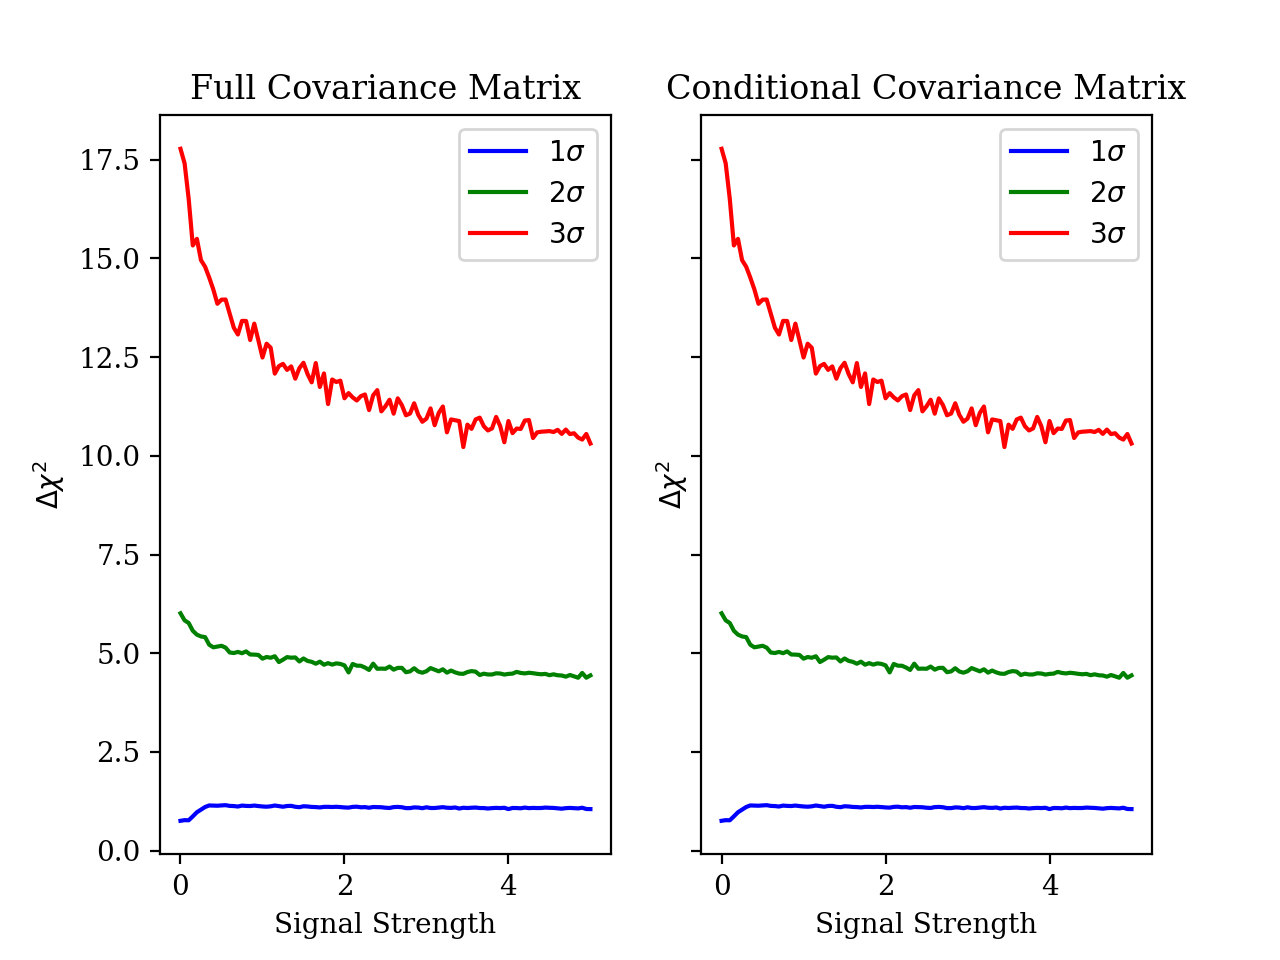

In [34]:
fig,ax = plt.subplots(1,2,sharey=True)

#bins=np.arange(0,50,1)

ax[0].plot(TRUE_VALS,critical_vals_tot[0],label="$1\sigma$")
ax[0].plot(TRUE_VALS,critical_vals_tot[1],label="$2\sigma$")
ax[0].plot(TRUE_VALS,critical_vals_tot[2],label="$3\sigma$")

ax[0].legend()
ax[0].set_ylabel("$\Delta\chi^2$")
ax[0].set_xlabel("Signal Strength")
ax[0].set_title("Full Covariance Matrix")

ax[1].plot(TRUE_VALS,critical_vals_tot[0],label="$1\sigma$")
ax[1].plot(TRUE_VALS,critical_vals_tot[1],label="$2\sigma$")
ax[1].plot(TRUE_VALS,critical_vals_tot[2],label="$3\sigma$")

ax[1].legend()
ax[1].set_ylabel("$\Delta\chi^2$")
ax[1].set_xlabel("Signal Strength")
ax[1].set_title("Conditional Covariance Matrix")

plt.show()
plt.savefig(tmp_plot())

In [35]:
df_pes_tot["mu_fit"] = df_pes_tot["mu_fit"].astype("float")
df_pes_tot["chi2_diff"] = df_pes_tot["chi2_diff"].astype("float")

df_pes_cond["mu_fit"] = df_pes_cond["mu_fit"].astype("float")
df_pes_cond["chi2_diff"] = df_pes_cond["chi2_diff"].astype("float")

<IPython.core.display.Javascript object>


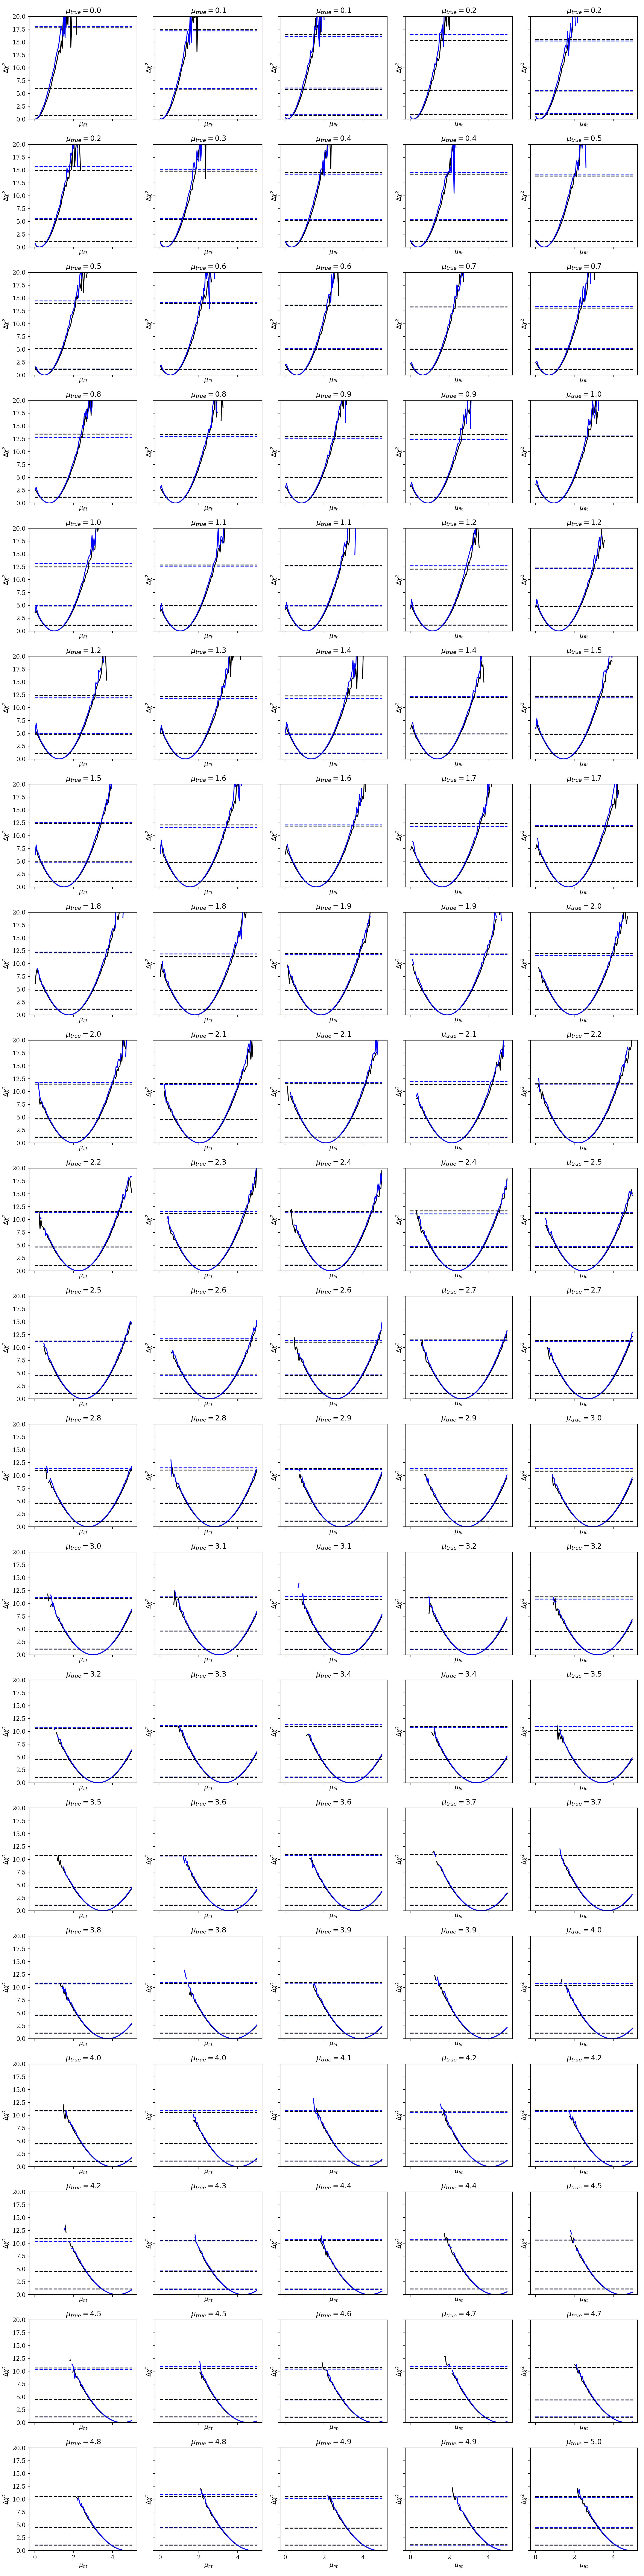

In [36]:
fig,ax = plt.subplots(int(len(TRUE_VALS)/5),5,sharex=True,sharey=True)
fig.set_size_inches(3*5, 3*int(len(TRUE_VALS)/5))

for itrue in range(len(TRUE_VALS)-1):
    iay=int(itrue/5)
    iax=itrue%5
    
    qstring = "abs(mu_true-%f)<0.001"%TRUE_VALS[itrue]

    res_tot = make_profile_bins(df_pes_tot.query(qstring),0,TRUE_VALS[-1],len(TRUE_VALS),"mu_fit","chi2_diff")
    res_cond = make_profile_bins(df_pes_cond.query(qstring),0,TRUE_VALS[-1],len(TRUE_VALS),"mu_fit","chi2_diff")
    #res_median = make_profile_bins(df_pes_tot.query(qstring),0,TRUE_VALS[-1],len(TRUE_VALS),"mu_fit","chi2_diff",func="median")


    ax[iay][iax].plot(res_tot["x"],res_tot["y"],color='k')
    ax[iay][iax].plot(res_cond["x"],res_cond["y"],color='b')
    #ax.plot(res_median["x"],res_median["median"],color='k',linestyle="-.")
    ax[iay][iax].hlines(xmin=0,xmax=TRUE_VALS[-1],y=critical_vals_cond[0][itrue],color='blue',linestyle="--",label="")
    ax[iay][iax].hlines(xmin=0,xmax=TRUE_VALS[-1],y=critical_vals_cond[1][itrue],color='blue',linestyle="--",label="")
    ax[iay][iax].hlines(xmin=0,xmax=TRUE_VALS[-1],y=critical_vals_cond[2][itrue],color='blue',linestyle="--",label="")
    ax[iay][iax].hlines(xmin=0,xmax=TRUE_VALS[-1],y=critical_vals_tot[0][itrue],color='k',linestyle="--",label="")
    ax[iay][iax].hlines(xmin=0,xmax=TRUE_VALS[-1],y=critical_vals_tot[1][itrue],color='k',linestyle="--",label="")
    ax[iay][iax].hlines(xmin=0,xmax=TRUE_VALS[-1],y=critical_vals_tot[2][itrue],color='k',linestyle="--",label="")
    #ax[iay][iax].set_ylim(bottom=0,top=critical_vals_cond[2][itrue]+10)

    #plt.legend()
    ax[iay][iax].set_ylabel("$\Delta\chi^2$")
    ax[iay][iax].set_xlabel("$\mu_{fit}$")
    ax[iay][iax].set_title("$\mu_{true}=%1.1f$"%TRUE_VALS[itrue])

plt.setp(ax, ylim=(0,20))
plt.tight_layout()
#plt.subplots_adjust(bottom=0.2,top=0.8)
plt.show()
plt.savefig(tmp_plot())

<IPython.core.display.Javascript object>


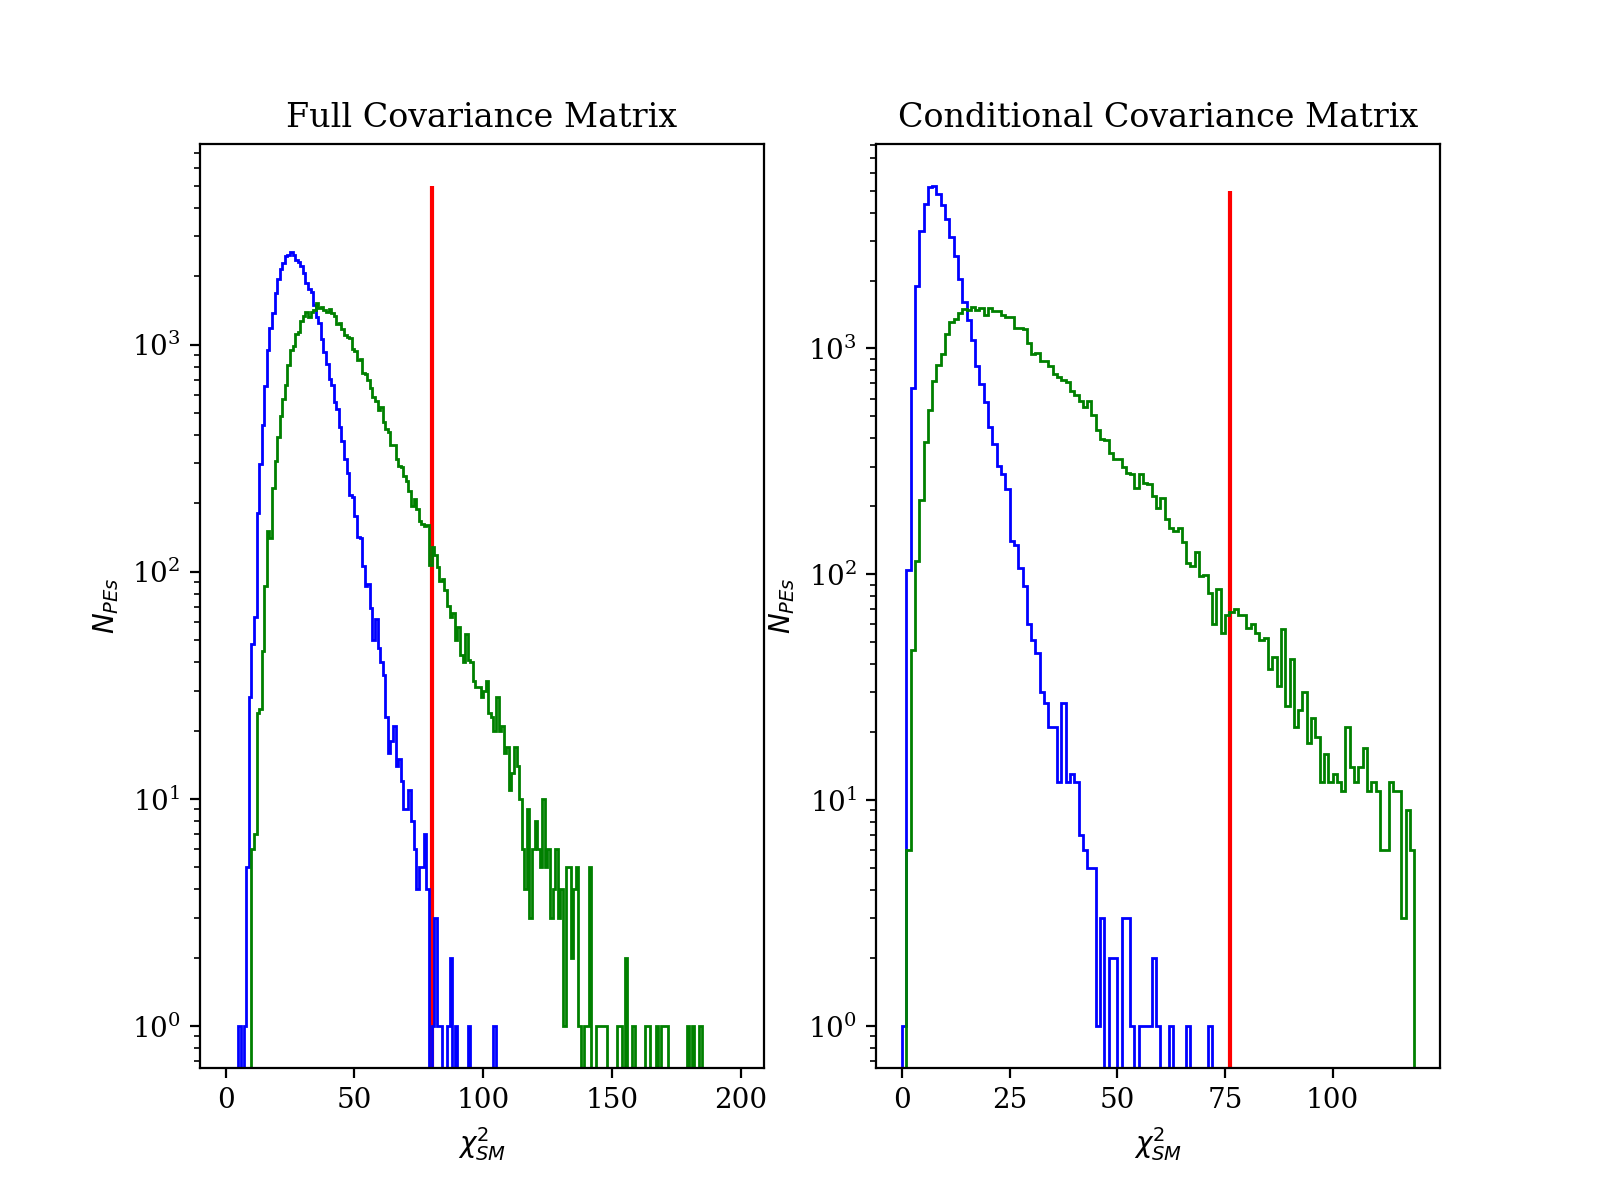

In [37]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(8, 6)

bins=np.arange(0,200,1)

ax[0].hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_h0"],bins=bins,label="$\mu_{true}=0.0$",histtype="step",log=True)
ax[0].hist(df_pes_tot.query("abs(mu_true-1.0)<0.001")["chi2_h0"],bins=bins,label="$\mu_{true}=1.0$",histtype="step",log=True)
ax[0].vlines(x=CHI2_SIG_FULL(0,DATA_OBS),ymin=0,ymax=5e3,color="r")

ax[0].set_xlabel("$\chi^2_{SM}$")
ax[0].set_ylabel("$N_{PEs}$")
ax[0].set_title("Full Covariance Matrix")

bins2=np.arange(0,120,1)

ax[1].hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_h0"],bins=bins2,label="$\mu_{true}=0.0$",histtype="step",log=True)
ax[1].hist(df_pes_cond.query("abs(mu_true-1.0)<0.001")["chi2_h0"],bins=bins2,label="$\mu_{true}=1.0$",histtype="step",log=True)
ax[1].vlines(x=CHI2_SIG_COND(0,NUE_OBS),ymin=0,ymax=5e3,color="r")

ax[1].set_xlabel("$\chi^2_{SM}$")
ax[1].set_ylabel("$N_{PEs}$")
ax[1].set_title("Conditional Covariance Matrix")

plt.show()
plt.savefig(tmp_plot())

<IPython.core.display.Javascript object>


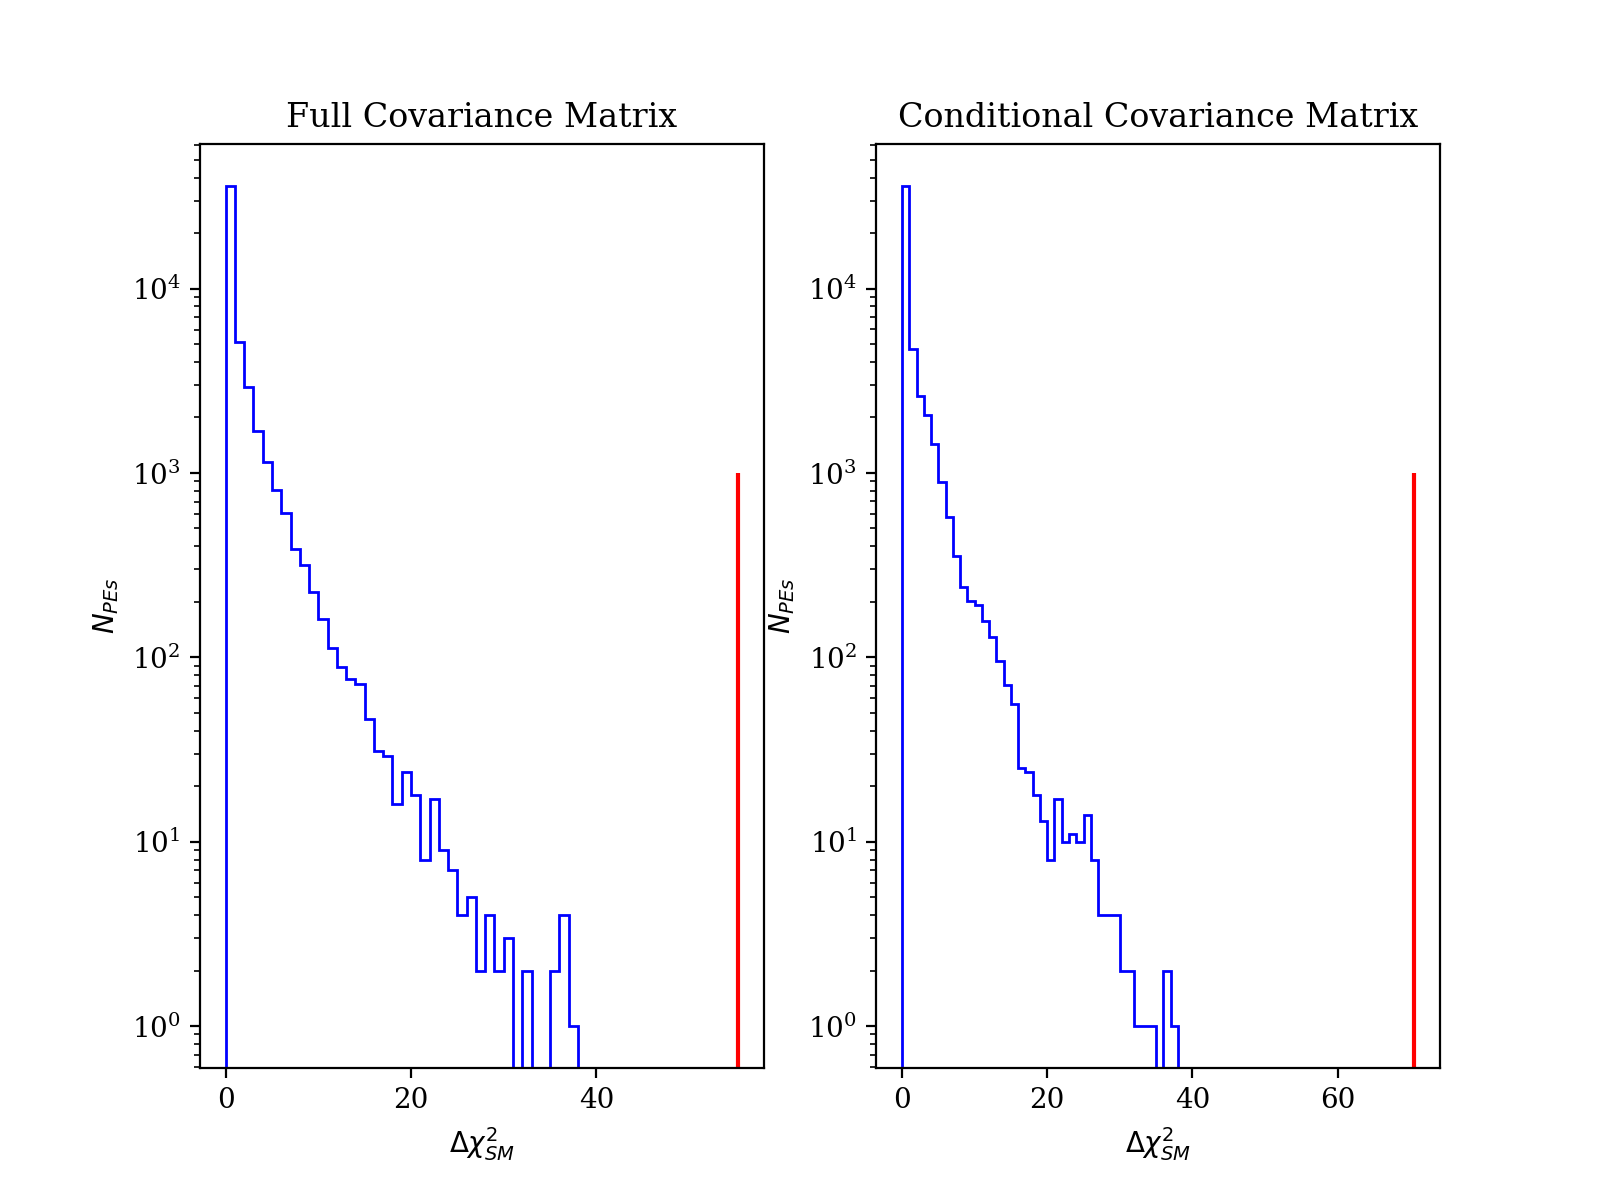

In [38]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(8, 6)

bins=np.arange(0,40,1)

ax[0].hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_diff"],bins=bins,label="$\mu_{true}=0.0$",histtype="step",log=True)
ax[0].vlines(x=CHI2_DIFF_FULL(DATA_OBS,[0]),ymin=0,ymax=1000,color="r")

ax[0].set_xlabel("$\Delta\chi^2_{SM}$")
ax[0].set_ylabel("$N_{PEs}$")
ax[0].set_title("Full Covariance Matrix")

bins2=np.arange(0,40,1)

ax[1].hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_diff"],bins=bins2,label="$\mu_{true}=0.0$",histtype="step",log=True)
ax[1].vlines(x=CHI2_DIFF_COND(NUE_OBS,[0]),ymin=0,ymax=1000,color="r")

ax[1].set_xlabel("$\Delta\chi^2_{SM}$")
ax[1].set_ylabel("$N_{PEs}$")
ax[1].set_title("Conditional Covariance Matrix")

plt.show()
plt.savefig(tmp_plot())

In [39]:
def CALC_COND_CHI2(pe):
    nue_exp = COND_EXP(pe[10:]-NUMU_EXP,NUE_EXP,M_COV_NUMU_INV,M_COV_EM)
    return CHI2(pe[:10]-nue_exp,np.linalg.inv(M_COV_COND_SYS+np.diagflat(nue_exp)))

In [40]:
df_pes_tot["chi2_cond"] = df_pes_tot["pe_data"].apply(lambda pe: CALC_COND_CHI2(pe))

In [41]:
df_pes_tot["chi2_numu"] = df_pes_tot["pe_data"].apply(lambda pe: CHI2(pe[10:]-NUMU_EXP,M_COV_NUMU_INV))

In [44]:
df_pes_tot["chi2_nue"] = df_pes_tot["pe_data"].apply(lambda pe: CHI2(pe[:10]-NUE_EXP,M_COV_NUE_INV))

In [45]:
df_pes_cond["chi2_nue"] = df_pes_cond["pe_data"].apply(lambda pe: CHI2(pe[:10]-NUE_EXP,M_COV_NUE_INV))

<IPython.core.display.Javascript object>


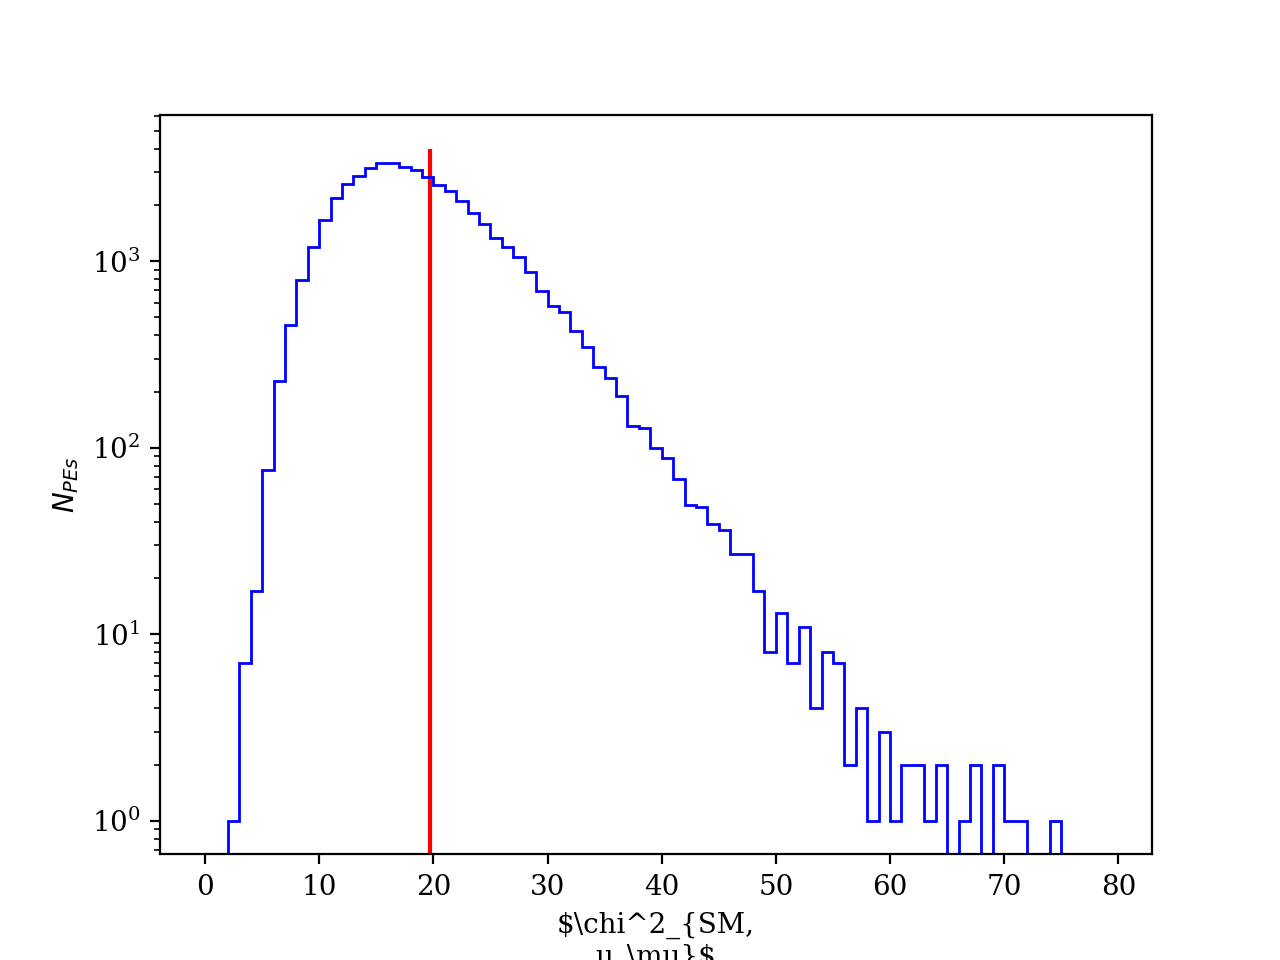

In [43]:
fig,ax = plt.subplots()

bins=np.arange(0,80,1)

ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_numu"],bins=bins,label="$\mu_{true}=0.0$",histtype="step",log=True)
ax.vlines(x=CHI2(NUMU_OBS-NUMU_EXP,M_COV_NUMU_INV),ymin=0,ymax=4000,color="r")

ax.set_xlabel("$\chi^2_{SM,\nu_\mu}$")
ax.set_ylabel("$N_{PEs}$")

plt.show()
plt.savefig(tmp_plot())

<IPython.core.display.Javascript object>


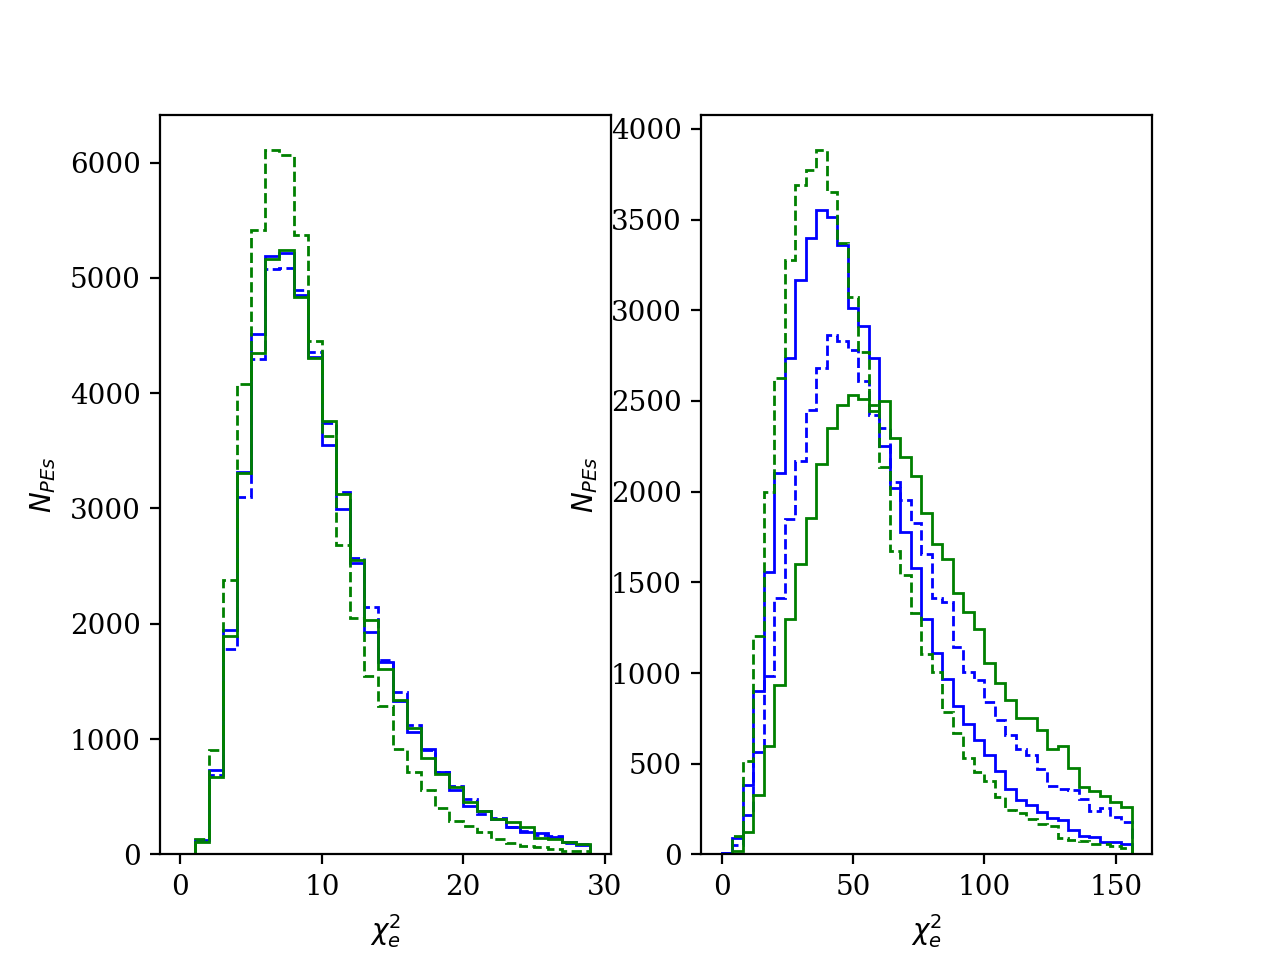

In [46]:
fig,ax = plt.subplots(1,2)

bins=np.arange(0,30,1)

ax[0].hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_nue"],bins=bins,label="PEs From Full",histtype="step")
ax[0].hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_cond"],bins=bins,label="PEs From Full",histtype="step",color='b',linestyle='--')
ax[0].hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_nue"],bins=bins,label="PEs From Constrained",histtype="step",linestyle='--')
ax[0].hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_h0"],bins=bins,label="PEs From Constrained",histtype="step",color='g')
#ax.vlines(x=CHI2(NUMU_OBS-NUMU_EXP,M_COV_NUMU_INV),ymin=0,ymax=1000,color="r")

ax[0].set_xlabel("$\chi^2_{e}$")
ax[0].set_ylabel("$N_{PEs}$")

bins2=np.arange(0,160,4)

ax[1].hist(df_pes_tot.query("abs(mu_true-2.0)<0.001")["chi2_nue"],bins=bins2,label="PEs From Full",histtype="step")
ax[1].hist(df_pes_tot.query("abs(mu_true-2.0)<0.001")["chi2_cond"],bins=bins2,label="PEs From Full",histtype="step",color='b',linestyle='--')
ax[1].hist(df_pes_cond.query("abs(mu_true-2.0)<0.001")["chi2_nue"],bins=bins2,label="PEs From Constrained",histtype="step",linestyle='--')
ax[1].hist(df_pes_cond.query("abs(mu_true-2.0)<0.001")["chi2_h0"],bins=bins2,label="PEs From Constrained",histtype="step",color='g')
#ax.vlines(x=CHI2(NUMU_OBS-NUMU_EXP,M_COV_NUMU_INV),ymin=0,ymax=1000,color="r")

ax[1].set_xlabel("$\chi^2_{e}$")
ax[1].set_ylabel("$N_{PEs}$")

plt.show()
plt.savefig(tmp_plot())

In [ ]:
print(SIG_EXP_COND/SIG_EXP[:10])
print(SIG_EXP[:10])

In [ ]:
chi2(nue_obs-nue_exp_cond,np.linalg.inv(m_cov_cond))

In [ ]:
print(nue_exp_cond)
print(m_cov_cond)
print(m_cov_cond_sys)

In [ ]:
for i in range(20):
    my_pe = get_pe(nue_exp_cond, m_cov_cond_sys)
    print(my_pe)
    print(chi2(my_pe-nue_exp_cond,np.linalg.inv(m_cov_cond)))

In [ ]:
df_pes_cond = pd.DataFrame()
for x in true_vals:
    print("\tRunning x=%f"%x)
    df_pes_cond = df_pes_cond.append(run_pes(n_pes,x,nue_exp_cond,sig_exp_cond[:10],m_cov_cond_sys))

In [ ]:
df_pes_cond

In [ ]:
df_pes_tot

In [ ]:
def get_fc_interval(chi2_diff,true_vals,critical_vals):
    vals = np.where(chi2_diff<critical_vals,true_vals,np.nan)
    vals = vals[~np.isnan(vals)]
    return (np.amin(vals),np.amax(vals),vals)
def get_fc_interval_min(chi2_diff,true_vals,critical_vals):
    vals = np.where(chi2_diff<critical_vals,true_vals,np.nan)
    vals = vals[~np.isnan(vals)]
    if len(vals)==0:
        return -1
    return np.amin(vals)
def get_fc_interval_max(chi2_diff,true_vals,critical_vals):
    vals = np.where(chi2_diff<critical_vals,true_vals,np.nan)
    vals = vals[~np.isnan(vals)]
    if len(vals)==0:
        return 9999
    return np.amax(vals)

In [ ]:
def chi2_diff(data,x_vals,sig,bkg,m_cov_inv):
    x0 = [0.1]
    res = scipy.optimize.minimize(chi2_sig,x0,
                                  args=(data,
                                        sig,
                                        bkg,
                                        m_cov_inv),
                                        bounds=[(0,100.)])
    chi2_hb_obs = chi2_sig(res.x[0],data=data,sig=sig,bkg=bkg,m_cov_inv=m_cov_inv)
    
    chi2_diff = np.empty(len(x_vals))
    for ix in range(len(x_vals)):
        chi2_diff[ix] = chi2_sig(x_vals[ix],data=data,sig=sig,bkg=bkg,m_cov_inv=m_cov_inv)-chi2_hb_obs
    return chi2_diff


In [ ]:
df_tmp = df_pes_tot.iloc[:10].copy()
#df_tmp["intvl_min_s1"], df_tmp["intvl_min_s2"] = zip(*df_tmp["pe_data"].apply(lambda pe: calc_fc_interval_numba(pe,true_vals,sig_exp,data_exp,m_cov_inv,critical_vals_tot[0])))
df_tmp["intervals"] = df_tmp["pe_data"].apply(lambda pe: calc_fc_interval_numba(pe,true_vals,sig_exp,data_exp,m_cov_inv,critical_vals_tot))


In [ ]:
df_tmp

In [ ]:
def add_fc_intervals(df_pes,x_vals,critical_vals,sig,bkg,m_cov_inv):
    df_pes["fc_interval_min_s1"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_min(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[0]))
    df_pes["fc_interval_max_s1"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_max(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[0]))
    df_pes["fc_interval_min_s2"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_min(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[1]))
    df_pes["fc_interval_max_s2"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_max(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[1]))
    #df_pes["fc_interval_min_s3"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_min(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[2]))
    #df_pes["fc_interval_max_s3"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_max(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[2]))
    
    df_pes["true_contained_s1"] = np.logical_and(df_pes["mu_true"]>=df_pes["fc_interval_min_s1"],
                                                 df_pes["mu_true"]<=df_pes["fc_interval_max_s1"])
    df_pes["true_contained_s2"] = np.logical_and(df_pes["mu_true"]>=df_pes["fc_interval_min_s2"],
                                                 df_pes["mu_true"]<=df_pes["fc_interval_max_s2"])
    #df_pes["true_contained_s3"] = np.logical_and(df_pes["mu_true"]>=df_pes["fc_interval_min_s3"],
    #                                             df_pes["mu_true"]<=df_pes["fc_interval_max_s3"])
    return df_pes

In [ ]:
diff_obs = chi2_diff(df_pes_tot.iloc[1]["pe_data"],true_vals,sig_exp,data_exp,m_cov_inv)

In [ ]:
for cval in critical_vals_tot:
    print(get_fc_interval(diff_obs,true_vals,cval))

In [ ]:
df_tmp = df_pes_tot.iloc[:10].copy()

In [ ]:
df_pes_tot = add_fc_intervals(df_pes_tot,true_vals,critical_vals_tot,sig_exp,data_exp,m_cov_inv)

In [ ]:
df_pes_cond["intervals"] = df_pes_cond["pe_data"].apply(lambda pe: calc_fc_interval_numba(pe,true_vals,sig_exp[:10],nue_exp_cond,np.linalg.inv(m_cov_cond),critical_vals_cond))

In [ ]:
df_pes_cond

In [ ]:
calc_fc_interval_numba(nue_obs,true_vals,sig_exp_cond[:10],nue_exp_cond,np.linalg.inv(m_cov_cond),critical_vals_cond)

In [ ]:
calc_fc_interval_numba(data_obs,true_vals,sig_exp,data_exp,np.linalg.inv(m_cov),critical_vals_tot)

In [ ]:
x0 = [0.1]
res = scipy.optimize.minimize(chi2_sig,x0,
                              args=(data_obs,
                                    sig_exp,
                                    data_exp,
                                    m_cov_inv),
                                    bounds=[(0,100.)])
print(res)

In [ ]:
x0 = [0.1]
res = scipy.optimize.minimize(chi2_sig,x0,
                              args=(nue_obs,
                                    sig_exp_cond,
                                    nue_exp_cond,
                                    np.linalg.inv(m_cov_cond)),
                                    bounds=[(0,100.)])
print(res)

In [ ]:
critical_vals_cond[0][0]

In [ ]:
critical_vals_cond[0][20]

In [ ]:
itrue = 40
qstring = "abs(mu_true-%f)<0.001"%true_vals[itrue]

df_pes_cond["mu_fit"] = df_pes_cond["mu_fit"].astype("float")
df_pes_cond["chi2_diff"] = df_pes_cond["chi2_diff"].astype("float")
res = make_profile_bins(df_pes_cond.query(qstring),0,true_vals[-1],len(true_vals),"mu_fit","chi2_diff")


fig,ax = plt.subplots()


ax.plot(res["x"],res["y"])
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[0][itrue],color='r',label="")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[1][itrue],color='r',label="")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[2][itrue],color='r',label="")


#plt.legend()
ax.set_ylabel("$\Delta\chi^2$")
ax.set_xlabel("$\mu_{fit}$")
plt.title("$\mu_{true}=%f$"%true_vals[itrue])

plt.show()
#plt.savefig("/Users/wketchum/Downloads/temp.pdf")


In [ ]:
itrue = 0
qstring = "abs(mu_true-%f)<0.001"%true_vals[itrue]

res_cond = make_profile_bins(df_pes_cond.query(qstring),0,true_vals[-1],int(len(true_vals)/2),"mu_fit","chi2_diff")
res_tot = make_profile_bins(df_pes_tot.query(qstring),0,true_vals[-1],int(len(true_vals)/2),"mu_fit","chi2_diff")


fig,ax = plt.subplots()


ax.plot(res_cond["x"],res_cond["y"],color='blue',label="Using Conditional Covariance Matrix")
ax.plot(res_tot["x"],res_tot["y"],color='black',label="Using Full Covariance Matrix")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[0][itrue],color='blue',linestyle="--")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[1][itrue],color='blue',linestyle="--")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[2][itrue],color='blue',linestyle="--")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_tot[0][itrue],color='k',linestyle="--")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_tot[1][itrue],color='k',linestyle="--")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_tot[2][itrue],color='k',linestyle="--")


plt.legend(loc=2)
ax.set_ylabel("$\Delta\chi^2$")
ax.set_xlabel("$\mu_{fit}$")
plt.title("$\mu_{true}=%f$"%true_vals[itrue])

plt.show()
plt.savefig("/Users/wketchum/Plots/temp_%d.pdf"%np.round(time.time()))

In [ ]:
def make_profile_bins(df,lowbin,hibin,nbins,xarg,yarg,option='sem',func='mean'):
    xbins = np.linspace(lowbin,hibin,nbins+1)
    diff = (xbins[1]-xbins[0])*0.00001
    xbins[-1] = xbins[-1]+diff
    result = (df[[xarg,yarg]].groupby(np.digitize(df[xarg],bins=xbins,right=False)))[yarg].agg([func,option])
    result = result.reindex(range(1,len(xbins),1))
    xbins[-1] = xbins[-1]-diff
    result["x"] = 0.5*(xbins[:-1]+xbins[1:])
    result["xerr"] = 0.5*(xbins[1]-xbins[0])
    result.rename(columns={func: 'y', option: 'yerr'}, inplace=True)
    return result

In [ ]:
itrue = 40
qstring = "abs(mu_true-%f)<0.001"%true_vals[itrue]

res_cond = make_profile_bins(df_pes_cond.query(qstring),0,true_vals[-1],len(true_vals),"mu_fit","chi2_diff",func="median")
res_tot = make_profile_bins(df_pes_tot.query(qstring),0,true_vals[-1],len(true_vals),"mu_fit","chi2_diff",func="median")

print(res_tot)

In [ ]:
res_median

In [ ]:
res_mean

In [ ]:
import time

In [ ]:
fig,ax = plt.subplots()
bins=np.arange(0,5,0.01)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.0)<0.05")["chi2_diff"],
        bins=bins,label="$0.95<\mu_{fit}<1.05$",histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.1)<0.05")["chi2_diff"],
        bins=bins,label="$1.05<\mu_{fit}<1.15$",histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.2)<0.05")["chi2_diff"],
        bins=bins,label="$1.15<\mu_{fit}<1.25$",histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.3)<0.05")["chi2_diff"],
        bins=bins,label="$1.25<\mu_{fit}<1.35$",histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.4)<0.05")["chi2_diff"],
        bins=bins,label="$1.35<\mu_{fit}<1.45$",histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.5)<0.05")["chi2_diff"],
        bins=bins,label="$1.45<\mu_{fit}<1.55$",histtype="step",log=True)
        

ax.set_xlabel("$\Delta\chi^2$")
ax.set_ylabel("$N_{PEs}$")

plt.legend()
plt.title("$\mu_{true}=1.0$")
plt.show()
plt.savefig("/Users/wketchum/Downloads/temp_%d.pdf"%np.round(time.time()))

In [ ]:
print(np.count_nonzero(df_pes_tot["true_contained_s1"])/len(df_pes_tot))
print(np.count_nonzero(df_pes_tot["true_contained_s2"])/len(df_pes_tot))
for x in true_vals:
    qstring=str("mu_true>(%f) and mu_true<(%f)"%(x-0.0001,x+0.0001))
    print("Coverage for x=%f: 1sigma=%f, 2sigma=%f"%(x,
                                                     np.count_nonzero(df_pes_tot.query(qstring)["true_contained_s1"])/len(df_pes_tot.query(qstring)),
                                                     np.count_nonzero(df_pes_tot.query(qstring)["true_contained_s2"])/len(df_pes_tot.query(qstring))))

In [ ]:
np.logical_and(df_tmp["mu_true"]>=df_tmp["fc_interval_min_s1"],df_tmp["mu_true"]<=df_tmp["fc_interval_max_s1"])

In [ ]:
df_tmp

In [ ]:
print chi2_diff(nue_obs,)

res = scipy.optimize.minimize(chi2_sig,x0,
                                  args=(nue_obs,
                                        sig_exp,
                                        nue_exp_cond,
                                        np.linalg.inv(m_cov_cond)),
                                        bounds=[(0,100.)])

In [ ]:
fig,ax = plt.subplots()

bins=np.arange(0,100,0.5)

ax.hist(df_pes.query("mu_true==0.0")["chi2_diff"],bins=bins,color='r',label="'H0'",histtype="step",log=True)
ax.hist(df_pes.query("mu_true==1.0")["chi2_diff"],bins=bins,color='b',label="'LEE x1'",histtype="step",log=True)
ax.hist(df_pes.query("mu_true==2.0")["chi2_diff"],bins=bins,color='g',label="'LEE x2'",histtype="step",log=True)

plt.legend()
ax.set_xlabel("$\Delta\chi^2$")
ax.set_ylabel("$N_{PEs}$")

plt.show()
plt.savefig("/Users/wketchum/Downloads/temp.pdf")

In [ ]:
fig,ax = plt.subplots()

bins=np.arange(0,10,0.1)

ax.hist(df_pes.query("mu_true==0.0")["mu_fit"],bins=bins,color='r',label="'H0'",histtype="step",log=True)
ax.hist(df_pes.query("mu_true==1.0")["mu_fit"],bins=bins,color='b',label="'LEE x1'",histtype="step",log=True)
ax.hist(df_pes.query("mu_true==2.0")["mu_fit"],bins=bins,color='g',label="'LEE x2'",histtype="step",log=True)

plt.legend()
ax.set_xlabel("Best Fit Signal Strength")
ax.set_ylabel("$N_{PEs}$")

plt.show()
plt.savefig("/Users/wketchum/Downloads/temp.pdf")

In [ ]:
df_pes.query("mu_true==0")["chi2_diff"]

In [ ]:
for x in np.arange(0,5.0,0.1):
    qstring=str("mu_true>(%f) and mu_true<(%f)"%(x-0.01,x+0.01))
    df_pes['mu_true'] = df_pes['mu_true'].astype(float)
    print("mu_true=%f"%x,np.quantile(df_pes.query(qstring)["chi2_diff"],[sigma1,sigma2,sigma3]))

In [ ]:
for x in np.arange(0,5.0,0.1):
    chi2_h0_obs = chi2(nue_obs-nue_exp_cond,np.linalg.inv(m_cov_cond))
    res = scipy.optimize.minimize(chi2_sig,x0,
                                  args=(nue_obs,
                                        sig_exp,
                                        nue_exp_cond,
                                        np.linalg.inv(m_cov_cond)),
                                        bounds=[(0,100.)])
    chi2_h1_obs = chi2_sig(x,data=nue_obs,sig=sig_exp,bkg=nue_exp_cond,m_cov_cond_inv=np.linalg.inv(m_cov_cond))
    chi2_hb_obs = chi2_sig(res.x,data=nue_obs,sig=sig_exp,bkg=nue_exp_cond,m_cov_cond_inv=np.linalg.inv(m_cov_cond))
    print("x=%f, chi2_h0_obs=%f, chi2_h1_obs=%f, chi2_hb_obs=%f, diff=%f (best fit=%f)"%(x,chi2_h0_obs,chi2_h1_obs,chi2_hb_obs,chi2_h1_obs-chi2_hb_obs,res.x[0]))

In [ ]:
hist_mu_00,bins = np.histogram(df_pes.query("mu_true==0")["mu_fit"].astype(float),bins=np.arange(0,10,0.1))

In [ ]:
hist_mu_00

In [ ]:
bins

In [ ]:
np.argmax(hist_mu_00[1:])+1

In [ ]:
def interval(df,level,prec=0.01):
    n_pes = len(df)
    hist_mu,bins = np.histogram(df,bins=np.arange(0,500,prec))
    init_max = np.argmax(hist_mu[1:])+1
    ilo = init_max
    ihi = init_max
    integral = hist_mu[init_max]
    
    while(integral < level*n_pes):
        if ilo==0:
            ihi += 1
            integral += hist_mu[ihi]
        elif(ihi==len(bins)-1):
            ilo -= 1
            integral += hist_mu[ilo]
        elif hist_mu[ilo-1]>hist_mu[ihi+1]:
            ilo -= 1
            integral += hist_mu[ilo]
        elif hist_mu[ilo-1]<=hist_mu[ihi+1]:
            ihi += 1
            integral += hist_mu[ihi]
    return bins[ilo], bins[ihi]+0.1, (integral/n_pes)

In [ ]:
interval(df_pes.query("mu_true==0.0")["mu_fit"],level=0.67)

In [ ]:
for x in np.arange(0,5.0,0.1):
    qstring=str("mu_true>(%f) and mu_true<(%f)"%(x-0.01,x+0.01))
    df_pes['mu_true'] = df_pes['mu_true'].astype(float)
    lo, hi, coverage = interval(df_pes.query(qstring)["mu_fit"],level=0.67)
    print("For true signal strength %f: %f < mu_fit < %f (coverage=%f)"%(x,lo,hi,coverage))

In [ ]:
chi2_h0_obs = chi2(nue_obs-nue_exp_cond,np.linalg.inv(m_cov_cond))
res = scipy.optimize.minimize(chi2_sig,x0,
                              args=(nue_obs,
                                    sig_exp,
                                    nue_exp_cond,
                                    np.linalg.inv(m_cov_cond)),
                                    bounds=[(0,100.)])
chi2_h1_obs = chi2_sig(res.x,data=nue_obs,sig=sig_exp,bkg=nue_exp_cond,m_cov_cond_inv=np.linalg.inv(m_cov_cond))
print("chi2_h0_obs=%f, chi2_h1_obs=%f, diff=%f (best fit=%f)"%(chi2_h0_obs,chi2_h1_obs,chi2_h0_obs-chi2_h1_obs,res.x[0]))

In [ ]:
len(df_pes.query("mu_true==0 and mu_fit>0.683232"))/len(df_pes.query("mu_true==0"))

In [ ]:
def confidence_bands(x_vals,df_pes,level,var="mu_fit",prec=0.01,verbose=False):
    x_lo = []
    x_hi = []
    for x in x_vals:
        qstring=str("mu_true>(%f) and mu_true<(%f)"%(x-0.001,x+0.001))
        df_pes['mu_true'] = df_pes['mu_true'].astype(float)
        lo, hi, coverage = interval(df_pes.query(qstring)[var],level,prec)
        x_lo.append(lo)
        x_hi.append(hi)
        if verbose:
            print("For true signal strength %f: %f < mu_fit < %f (coverage=%f)"%(x,lo,hi,coverage))
    return x_lo, x_hi

In [ ]:
x_vals = np.arange(0,5.,0.1)
sigma1 = scipy.stats.norm(0,1).cdf(1)-scipy.stats.norm(0,1).cdf(-1)
sigma2 = scipy.stats.norm(0,1).cdf(2)-scipy.stats.norm(0,1).cdf(-2)
sigma3 = scipy.stats.norm(0,1).cdf(3)-scipy.stats.norm(0,1).cdf(-3)

x_lo1, x_hi1 = confidence_bands(x_vals,df_pes,level=sigma1,prec=0.05)
x_lo2, x_hi2 = confidence_bands(x_vals,df_pes,level=sigma2,prec=0.05)
x_lo3, x_hi3 = confidence_bands(x_vals,df_pes,level=sigma3,prec=0.05)

In [ ]:
len(df_pes.query("mu_true==0 and chi2_diff>4.686515"))/len(df_pes.query("mu_true==0"))

In [ ]:
fig,ax = plt.subplots()

ax.plot(x_lo1,x_vals,color='b',label="$1\sigma$")
ax.plot(x_hi1,x_vals,color='b')

ax.plot(x_lo2,x_vals,color='b',linestyle="--",label="$2\sigma$")
ax.plot(x_hi2,x_vals,color='b',linestyle="--")

ax.plot(x_lo3,x_vals,color='b',linestyle="dotted",label="$3\sigma$")
ax.plot(x_hi3,x_vals,color='b',linestyle="dotted")

ax.vlines(x=res.x[0],ymin=x_vals[0],ymax=x_vals[-1],color='r',label="Observed, Fake Dataset2")

plt.legend(loc=4)
ax.set_xlabel("Fit Signal Strength")
ax.set_ylabel("True Signal Strength")

plt.grid(True)
plt.show()
plt.savefig("/Users/wketchum/Downloads/temp.pdf")

In [ ]:
x_vals = np.arange(0,5.,0.1)
sigma1 = scipy.stats.norm(0,1).cdf(1)-scipy.stats.norm(0,1).cdf(-1)
sigma2 = scipy.stats.norm(0,1).cdf(2)-scipy.stats.norm(0,1).cdf(-2)
sigma3 = scipy.stats.norm(0,1).cdf(3)-scipy.stats.norm(0,1).cdf(-3)

x_lo1, x_hi1 = confidence_bands(x_vals,df_pes,level=sigma1,var="chi2_diff",prec=1.)
x_lo2, x_hi2 = confidence_bands(x_vals,df_pes,level=sigma2,var="chi2_diff",prec=1.)
#x_lo3, x_hi3 = confidence_bands(x_vals,df_pes,level=sigma3,var="chi2_diff",prec=1.)

In [ ]:
fig,ax = plt.subplots()

ax.plot(x_lo1,x_vals,color='b',label="$1\sigma$")
ax.plot(x_hi1,x_vals,color='b')

ax.plot(x_lo2,x_vals,color='b',linestyle="--",label="$2\sigma$")
ax.plot(x_hi2,x_vals,color='b',linestyle="--")

#ax.plot(x_lo3,x_vals,color='b',linestyle="dotted",label="$3\sigma$")
#ax.plot(x_hi3,x_vals,color='b',linestyle="dotted")

ax.vlines(x=(chi2_h0_obs-chi2_h1_obs),ymin=x_vals[0],ymax=x_vals[-1],color='r',label="Observed, Fake Dataset2")

plt.legend(loc=4)
ax.set_xlabel("$\Delta\chi^2$")
ax.set_ylabel("True Signal Strength")

ax.set_xlim(left=0.,right=100.)
plt.grid(True)
plt.show()
plt.savefig("/Users/wketchum/Downloads/temp.pdf")